In [18]:
import torch 
import torch.nn as nn
import torch.optim as optim 
import torchvision 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [20]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [21]:
latent_dim=100
lr=0.0002
beta1=0.5 
beta2=0.999
num_epochs=10 

generator 

In [40]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128*8*8),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 8, 8)),
            
            nn.Upsample(scale_factor=2),  # 8x8 -> 16x16
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),  # Fixed: 64 -> 128
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2),  # 16x16 -> 32x32
            nn.Conv2d(128, 64, 3, stride=1, padding=1),  # Fixed: added this layer
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(),
            
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        return img

discreminator 

In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 32 x 16 x 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),  # Fixed: 0,.25 -> 0.25
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64 x 8 x 8
            nn.ZeroPad2d((0, 1, 0, 1)),  # 64 x 9 x 9
            nn.BatchNorm2d(64, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 128 x 5 x 5
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            
            nn.Flatten(),  # 128 * 5 * 5 = 3200
            nn.Linear(128 * 5 * 5, 1),  # Fixed: 256*5*5 -> 128*5*5
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity



In [47]:
generator=Generator().to(device)
discriminator=Discriminator().to(device)
adversarial_loss=nn.BCELoss()
optimizer_G=optim.Adam(generator.parameters(),lr=lr,betas=(beta1,beta2))
optimizer_D=optim.Adam(discriminator.parameters(),lr=lr,betas=(beta1,beta2))


training the gan 

Epoch [1/10], Step [100/391], D Loss: 0.7500, G Loss: 0.7985
Epoch [1/10], Step [200/391], D Loss: 0.6916, G Loss: 0.7876
Epoch [1/10], Step [300/391], D Loss: 0.6568, G Loss: 0.8487
Epoch [2/10], Step [100/391], D Loss: 0.7639, G Loss: 0.7113
Epoch [2/10], Step [200/391], D Loss: 0.6779, G Loss: 0.8649
Epoch [2/10], Step [300/391], D Loss: 0.7217, G Loss: 0.7863
Epoch [3/10], Step [100/391], D Loss: 0.6607, G Loss: 0.8223
Epoch [3/10], Step [200/391], D Loss: 0.6779, G Loss: 0.8543
Epoch [3/10], Step [300/391], D Loss: 0.6507, G Loss: 0.8124
Epoch [4/10], Step [100/391], D Loss: 0.6537, G Loss: 0.8541
Epoch [4/10], Step [200/391], D Loss: 0.6896, G Loss: 0.7647
Epoch [4/10], Step [300/391], D Loss: 0.6601, G Loss: 0.7826
Epoch [5/10], Step [100/391], D Loss: 0.6277, G Loss: 0.8820
Epoch [5/10], Step [200/391], D Loss: 0.6590, G Loss: 0.8028
Epoch [5/10], Step [300/391], D Loss: 0.6934, G Loss: 0.8584
Epoch [6/10], Step [100/391], D Loss: 0.6755, G Loss: 0.7909
Epoch [6/10], Step [200/

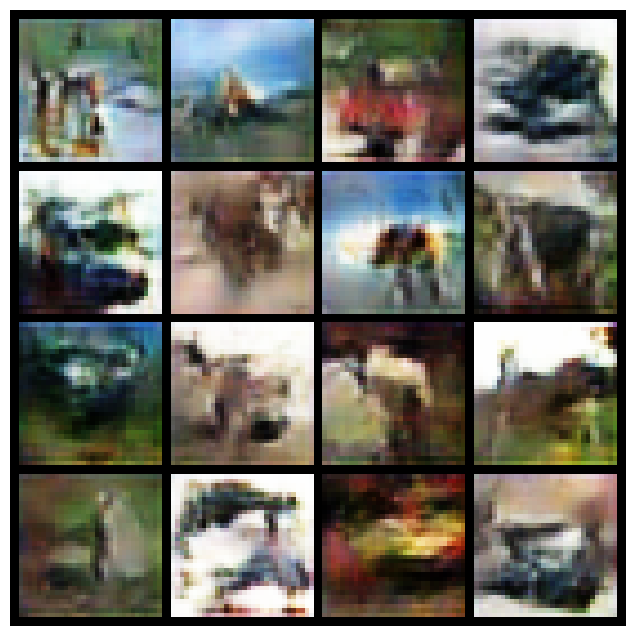

In [48]:
for epoch in range(num_epochs):
    for i, batch in enumerate(train_loader):
        real_images = batch[0].to(device)  # Fixed: to_device -> to, removed extra comma
        valid = torch.ones(real_images.size(0), 1, device=device)  # Fixed: removed trailing comma
        fake = torch.zeros(real_images.size(0), 1, device=device)
        
        # Removed duplicate: real_images = real_images.to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)
        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # Train Generator
        optimizer_G.zero_grad()
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()
        
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    
    # Fixed: moved to epoch level (removed extra indentation)
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            gen_images = generator(z)
            gen_images = gen_images.cpu()
            grid = torchvision.utils.make_grid(gen_images, nrow=4, normalize=True)
            plt.figure(figsize=(8, 8))
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis('off')
            plt.show()  # Fixed: removed trailing comma